In [27]:
import gym
from gym import spaces
import numpy as np

class MarineFoulingCleaningEnv(gym.Env):
    def __init__(self, max_steps=50):
        super(MarineFoulingCleaningEnv, self).__init__()

        # Define a state space range
        # Assuming states are [hardPerc, hardmm, softPerc, softmm]
        self.observation_space = spaces.Box(low=np.array([0, 0, 0, 0]), 
                                            high=np.array([100, 100, 100, 100]), 
                                            dtype=np.float32)
        
        # Define an action space range
        # Assuming 4 different cleaning methods
        self.action_space = spaces.Discrete(4)
        self.max_steps = max_steps
        self.current_step = 0
        self.success_threshold = 0.1

    def step(self, action):
        # Apply action and determine reward
        # Here, we're just simulating the effect of an action. This would be more complex in a real situation.
        self.current_step += 1  # Increment the step count
        done = self._is_done()
        reward = self._calculate_reward(action)
        self.state = self._next_state(action)
        done = self._is_done()

        return self.state, reward, done, {}

    def reset(self):
        # Reset the state to a new random state
        self.state = self.observation_space.sample()
        return self.state

    def render(self, mode='console'):
        if mode == 'console':
            print(f"Current state: {self.state}")
    
    def seed(self, seed=None):
        np.random.seed(seed)

    def _calculate_reward(self, action):
        # Simulated effectiveness scores for each cleaning method
        effectiveness_scores = [0.8, 0.7, 0.9, 0.6]  # These values are hypothetical

        # Calculate the reward based on the effectiveness of the chosen action and the current state
        # For simplicity, let's assume the reward is proportional to the reduction in fouling
        reward = 0
        for i in range(4):  # Loop over the fouling components in the state
            reward += effectiveness_scores[action] * (100 - self.state[i]) / 100

        return reward

    def _next_state(self, action):
        # Define the efficiency of each cleaning method
        # These values represent the percentage reduction in fouling
        efficiency = {
            0: {'hard': 0.3, 'soft': 0.2},  # Cleaning method 0
            1: {'hard': 0.1, 'soft': 0.5},  # Cleaning method 1
            2: {'hard': 0.4, 'soft': 0.1},  # Cleaning method 2
            3: {'hard': 0.2, 'soft': 0.3}   # Cleaning method 3
        }

        # Update the state based on the efficiency of the chosen action
        hard_fouling_reduction = efficiency[action]['hard']
        soft_fouling_reduction = efficiency[action]['soft']

        # Apply reduction to hard and soft fouling components
        self.state[0] = max(0, self.state[0] - hard_fouling_reduction * self.state[0])
        self.state[1] = max(0, self.state[1] - hard_fouling_reduction * self.state[1])
        self.state[2] = max(0, self.state[2] - soft_fouling_reduction * self.state[2])
        self.state[3] = max(0, self.state[3] - soft_fouling_reduction * self.state[3])

        return self.state

    def _is_done(self):
        # Check if the fouling levels are below the success threshold
        fouling_levels = self.state[:4]  # Assuming the first four elements are fouling levels
        fouling_reduced = all(fouling <= self.success_threshold for fouling in fouling_levels)

        # Check if maximum number of steps has been reached
        max_steps_reached = self.current_step >= self.max_steps

        # The episode is done if successful cleaning is achieved or max steps are reached
        return fouling_reduced or max_steps_reached

# Example usage
env = MarineFoulingCleaningEnv()
state = env.reset()
print("Initial state:", state)

for _ in range(10):
    action = env.action_space.sample()  # Select a random action
    state, reward, done, _ = env.step(action)
    print(f"State: {state}, Reward: {reward}, Done: {done}")
    if done:
        break

Initial state: [14.270558 51.818443 62.24427  58.805504]
State: [ 8.562335 31.091066 56.019844 52.924953], Reward: 1.915751017570496, Done: False
State: [ 5.137401 18.65464  50.41786  47.632458], Reward: 2.262616209983826, Done: False
State: [ 3.5961807 13.0582485 40.334286  38.105965 ], Reward: 2.225261142730713, Done: False
State: [ 2.5173264  9.140774  32.26743   30.484772 ], Reward: 2.4392425632476806, Done: False
State: [ 2.0138612  7.312619  22.5872    21.33934  ], Reward: 1.9535381927490234, Done: False
State: [ 1.8124751  6.5813575 11.2936    10.66967  ], Reward: 2.427228854656219, Done: False
State: [1.2687325 4.6069503 9.03488   8.535736 ], Reward: 2.9571431779861452, Done: False
State: [0.7612395 2.7641702 8.131392  7.6821623], Reward: 3.3889833126068116, Done: False
State: [0.45674372 1.6585021  7.3182526  6.913946  ], Reward: 3.425949328422546, Done: False
State: [0.36539498 1.3268017  5.122777   4.839762  ], Reward: 2.3019153327941893, Done: False


In [50]:
import pandas as pd

class MarineFoulingCleaningEnv(gym.Env):
    def __init__(self, dataset, max_steps=50):
        super(MarineFoulingCleaningEnv, self).__init__()

        # Load the dataset
        self.dataset = pd.read_csv(dataset)

        # Define a state space range based on the dataset
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([100, 100, 100, 100], dtype=np.float32), 
            dtype=np.float32
            )
        
        # Define an action space range
        self.action_space = spaces.Discrete(4)  # Assuming 4 different cleaning methods
        self.max_steps = max_steps
        self.current_step = 0
        self.success_threshold = 0.1

    def step(self, action):
        # Apply action and determine reward
        self.current_step += 1
        reward = self._calculate_reward(action)
        self.state = self._next_state(action)
        done = self._is_done()
        return self.state, reward, done, {}

    def reset(self):
        # Reset the state using a new sample from the dataset
        self.state = self.dataset.sample()[['hardPerc', 'hardmm', 'softPerc', 'softmm']].values.flatten()
        self.current_step = 0
        return self.state

    def render(self, mode='console'):
        if mode == 'console':
            print(f"Current state: {self.state}")

    def seed(self, seed=None):
        np.random.seed(seed)

    def _calculate_reward(self, action):
        # Simulated effectiveness scores for each cleaning method
        effectiveness_scores = [0.8, 0.7, 0.9, 0.6]  # These values are hypothetical

        # Calculate the reward based on the effectiveness of the chosen action and the current state
        # For simplicity, let's assume the reward is proportional to the reduction in fouling
        reward = 0
        for i in range(4):  # Loop over the fouling components in the state
            reward += effectiveness_scores[action] * (100 - self.state[i]) / 100

        return reward

    def _next_state(self, action):
        # Define the efficiency of each cleaning method
        # These values represent the percentage reduction in fouling
        efficiency = {
            0: {'hard': 0.3, 'soft': 0.2},  # Cleaning method 0
            1: {'hard': 0.1, 'soft': 0.5},  # Cleaning method 1
            2: {'hard': 0.4, 'soft': 0.1},  # Cleaning method 2
            3: {'hard': 0.2, 'soft': 0.3}   # Cleaning method 3
        }

        # Update the state based on the efficiency of the chosen action
        hard_fouling_reduction = efficiency[action]['hard']
        soft_fouling_reduction = efficiency[action]['soft']

        # Apply reduction to hard and soft fouling components
        self.state = [
            max(0, value - hard_fouling_reduction * value) if index < 2 else
            max(0, value - soft_fouling_reduction * value)
            for index, value in enumerate(self.state)
        ]

        return self.state

    def _is_done(self):
        # Check if the fouling levels are below the success threshold
        fouling_levels = self.state[:4]  # Assuming the first four elements are fouling levels
        fouling_reduced = all(fouling <= self.success_threshold for fouling in fouling_levels)

        # Check if maximum number of steps has been reached
        max_steps_reached = self.current_step >= self.max_steps

        # The episode is done if successful cleaning is achieved or max steps are reached
        return fouling_reduced or max_steps_reached

# Example of initializing the environment with a dataset
env = MarineFoulingCleaningEnv('/workspaces/UnderWater-Decision/data/default_synthetic_dataset.csv')

state = env.reset()
print("Initial state:", state)

for _ in range(10):
    action = env.action_space.sample()  # Select a random action
    state, reward, done, _ = env.step(action)
    print(f"State: {state}, Reward: {reward}, Done: {done}")
    if done:
        break

Initial state: [ 82 175  18 192]
State: [65.6, 140.0, 12.600000000000001, 134.4], Reward: -0.402, Done: False
State: [39.36, 84.0, 11.340000000000002, 120.96000000000001], Reward: 0.42660000000000015, Done: False
State: [35.424, 75.6, 5.670000000000001, 60.480000000000004], Reward: 1.01038, Done: False
State: [21.254399999999997, 45.36, 5.103000000000001, 54.432], Reward: 2.005434, Done: False
State: [12.752639999999998, 27.215999999999998, 4.592700000000001, 48.9888], Reward: 2.4646554, Done: False
State: [7.651583999999998, 16.3296, 4.133430000000001, 44.08992], Reward: 2.75804874, Done: False
State: [4.590950399999999, 9.79776, 3.7200870000000004, 39.680928], Reward: 2.9501591940000003, Done: False
State: [3.672760319999999, 7.838208, 2.6040609000000003, 27.7766496], Reward: 2.0532616476, Done: False
State: [2.9382082559999994, 6.2705664, 1.8228426300000002, 19.443654719999998], Reward: 2.14864992708, Done: False
State: [2.3505666047999996, 5.0164531199999995, 1.2759898410000003, 13

In [91]:
from stable_baselines3.common.callbacks import BaseCallback

# class CustomCallback(BaseCallback):
#     def __init__(self, logger, verbose=0):
#         super().__init__(verbose)
#         if not isinstance(logger, MetricLogger):
#             raise TypeError("logger must be an instance of MetricLogger")
#         self.logger = logger

#     def _on_step(self):
#         infos = self.locals.get('infos')
#         if infos:
#             for info in infos:
#                 if 'episode' in info:
#                     total_reward = info['episode']['r']
#                     self.logger.log_reward(total_reward)
#         return True

class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

class MetricLogger:
    def __init__(self):
        self.rewards = []
        self.losses = []
        self.exploration_rates = []

    def log_reward(self, reward):
        self.rewards.append(reward)

    def log_loss(self, loss):
        self.losses.append(loss)

    def log_exploration_rate(self, rate):
        self.exploration_rates.append(rate)

    def get_average_reward(self, last_n_episodes=100):
        """Calculate the average reward for the last n episodes."""
        if len(self.rewards) < last_n_episodes:
            return sum(self.rewards) / len(self.rewards)
        else:
            return sum(self.rewards[-last_n_episodes:]) / last_n_episodes

    def reset(self):
        """Resets the stored metrics."""
        self.rewards = []
        self.losses = []
        self.exploration_rates = []

In [92]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

# Initialize your custom environment
env = MarineFoulingCleaningEnv('/workspaces/UnderWater-Decision/data/default_synthetic_dataset.csv')

# Initialize the metric logger
logger = MetricLogger()

# Wrap the environment
env = make_vec_env(lambda: env, n_envs=1)

# Create the agent
model = DQN("MlpPolicy", env, verbose=1)

# Initialize the custom callback with the logger
callback = CustomCallback(logger)

# Train the agent with the callback
model.learn(total_timesteps=10000, callback=callback)

# Save the agent
model.save("dqn_marine_fouling_cleaning")

# Now you can use logger to access logged rewards and other metrics


Using cuda device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.8     |
|    ep_rew_mean      | 64.2     |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7933     |
|    time_elapsed     | 0        |
|    total_timesteps  | 91       |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 24.2     |
|    ep_rew_mean      | 66.3     |
|    exploration_rate | 0.816    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7341     |
|    time_elapsed     | 0        |
|    total_timesteps  | 194      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.2     |
|    ep_rew_mean      | 67.4     |
|    exploration_rate | 0.713    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 7589     |
|    time_elapsed     | 0        |
|    total_timesteps  | 302      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.6     |
|    ep_rew_mean      | 67.8     |
|    exploration_rate | 0.611    |
| time/               |          |
|    episodes       

/opt/miniconda/envs/uw-decision/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.2     |
|    ep_rew_mean      | 66.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 64       |
|    fps              | 7936     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1610     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.1     |
|    ep_rew_mean      | 66.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 7999     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1708     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.3     |
|    ep_rew_mean      | 66.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

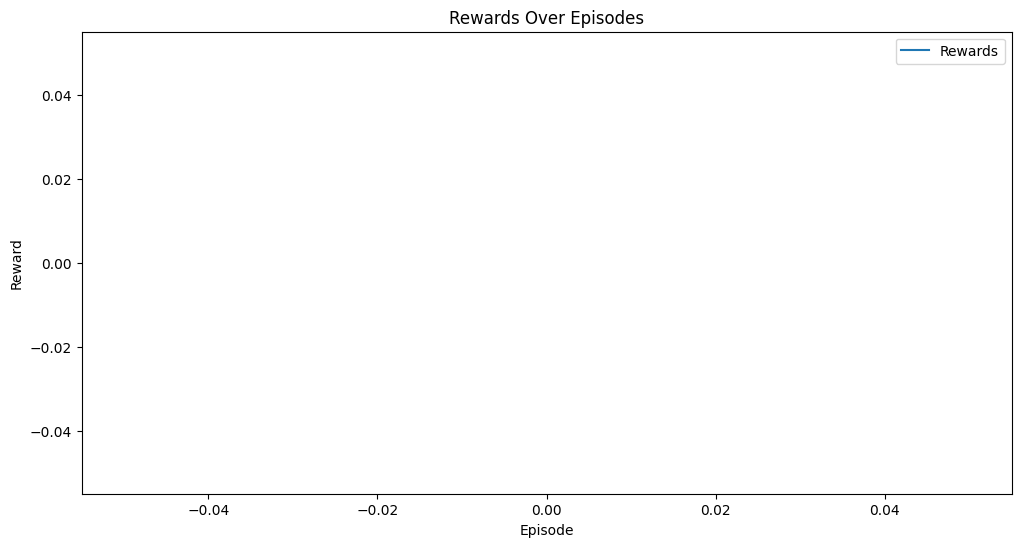

In [93]:
import matplotlib.pyplot as plt

# Assuming logger is your MetricLogger instance
rewards = logger.rewards

# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Over Episodes')
plt.legend()
plt.show()

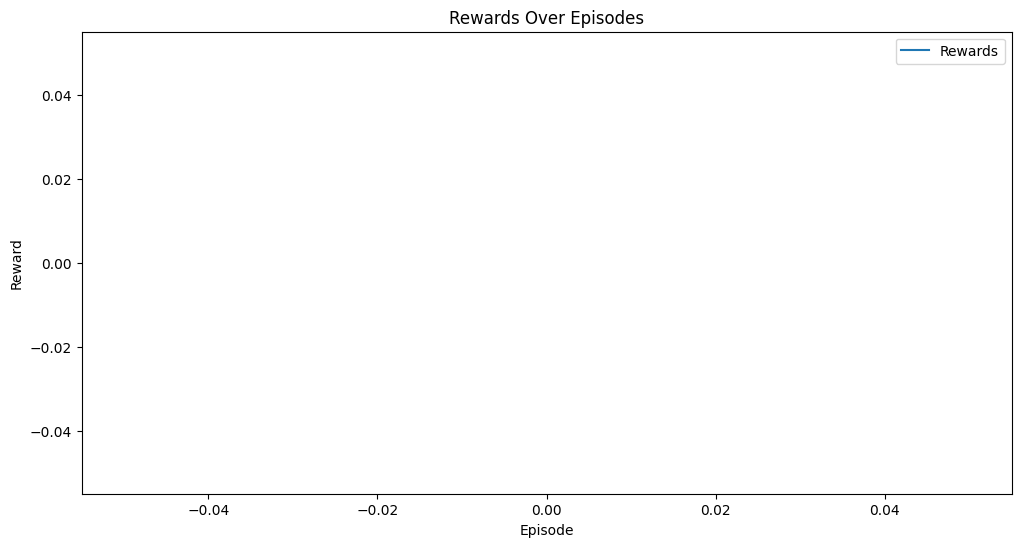

In [94]:
import matplotlib.pyplot as plt

# Assuming logger is your MetricLogger instance
rewards = logger.rewards

# Plot rewards
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Over Episodes')
plt.legend()
plt.show()


In [95]:
rewards

[]